# House Prices: Advanced Regression Techniques
Author: Matthew Huh

### About the data

The data for this project has been obtained from Kaggle. The dataset contains a collection of 1460 individual properties with 81 attributes.

### Research question

Using the 81 attributes and a rather limited number of samples, can we build a sufficiently accurate model for estimating property values in Ames, Iowa?

### Source

House Prices: Advanced Regression Techniques
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [1]:
# Imports

# Necessary imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import warnings
warnings.filterwarnings('ignore')

# Visualization packages
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modelling packages
from sklearn import ensemble, linear_model
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
from sklearn.utils import resample

# Plotly packages
import cufflinks as cf
import ipywidgets as widgets
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
from scipy import special
py.offline.init_notebook_mode(connected=True)

C:\Users\mhuh22\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Import the data
housing_train = pd.read_csv("train.csv")
housing_test = pd.read_csv("test.csv")

# Drop the 'id' column since it's not a predictor
housing_train.drop(['Id'], axis=1, inplace=True)

# Preview the dataset
housing_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Print the size of the dataframe
print('Size of the dataframe: {} listings x {} features'.format(housing_train.shape[0],housing_train.shape[1]))

Size of the dataframe: 1460 listings x 80 features


At 1460 units, this is a fairly small dataset, but it seems as though we at least have 80 features to work with. I have listed all of them below if you would like to see,

In [4]:
# View all 80 data columns
print('Column names: \n\n', housing_train.columns)

Column names: 

 Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       

In [5]:
# Check for any missing values
print('Missing values: \n\n', housing_train.isna().sum().sort_values(ascending=False).head(20))

Missing values: 

 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64


So, quite a few of features seem to be missing values for the majority of data points, like poolqc, misc features, alley, fence, fireplacequ, and lotfrontage. For the columns that are missing an excessive number of values, it seems safe to impute the value of 0 to signify that these traits are not present.

In [6]:
# Impute missing values in these categories with 0
housing_train[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']].fillna(0, inplace=True)

### Exploratory Data Analysis

Let's begine the exploratory process by viewing the outcome that we want to measure. In this case, it's the sale price.

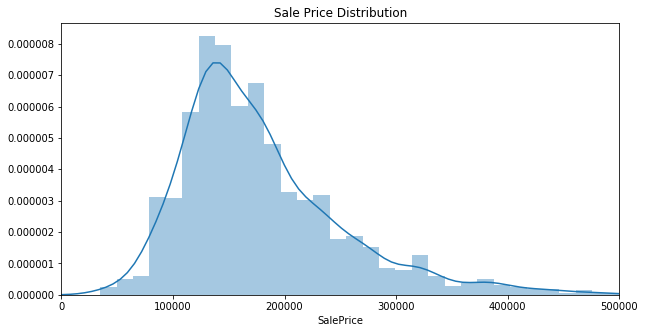

In [7]:
# Visualize the distribution of housing prices
plt.rcParams['figure.figsize'] = [10,5]

plt.xlim(0,500000)
plt.title('Sale Price Distribution')
sns.distplot(housing_train['SalePrice'])

So, it seems as though the sale price does not follow a normal distribution curve. The majority of houses seem to fall between 129,000 and 214,000 range, while the most expensive is a staggering 755,000.

In [8]:
# View descriptive statistics for all numerical categories
housing_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
# Describe unique occurences for each categorical variable
print('Unique values for each feature: \n\n', housing_train.nunique().sort_values(ascending = False).head(20))

Unique values for each feature: 

 LotArea          1073
GrLivArea         861
BsmtUnfSF         780
1stFlrSF          753
TotalBsmtSF       721
SalePrice         663
BsmtFinSF1        637
GarageArea        441
2ndFlrSF          417
MasVnrArea        327
WoodDeckSF        274
OpenPorchSF       202
BsmtFinSF2        144
EnclosedPorch     120
YearBuilt         112
LotFrontage       110
GarageYrBlt        97
ScreenPorch        76
YearRemodAdd       61
Neighborhood       25
dtype: int64


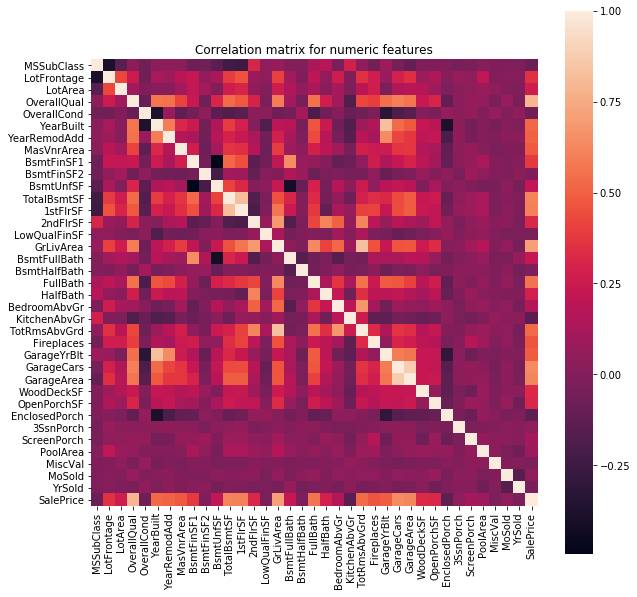

In [10]:
# Creates a correlation matrix among the predictor variables
plt.rcParams['figure.figsize'] = [10, 10]

plt.title('Correlation matrix for numeric features')
correlation_martix = housing_train.corr()
sns.heatmap(correlation_martix, vmax = 1, square = True)
plt.show()

In [11]:
# Impute all remaining missing values with 0s
housing_train.fillna(0, inplace=True)
housing_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [12]:
# Temporarily ignore non-numeric values
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_housing_train = housing_train.select_dtypes(include=numerics)

In [13]:
# Identify the input and output variables
X = numeric_housing_train.drop('SalePrice', axis=1)
y = housing_train['SalePrice']

In [14]:
# Divide the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
# Create dataframe to track runtime and scores
models = ['Logistic regression' , 'Random forest']
runtime = []
train_score = []
test_score = []

In [16]:
# Create a linear regression model
lr = linear_model.LinearRegression()

# Fit the model to the data, and predict values
lr.fit(X, y)
y_pred = lr.predict(X)

# Print the overall accuracy of the model
print('Linear regression score:', lr.score(X_test, y_test))

Score: 0.8135143518823432


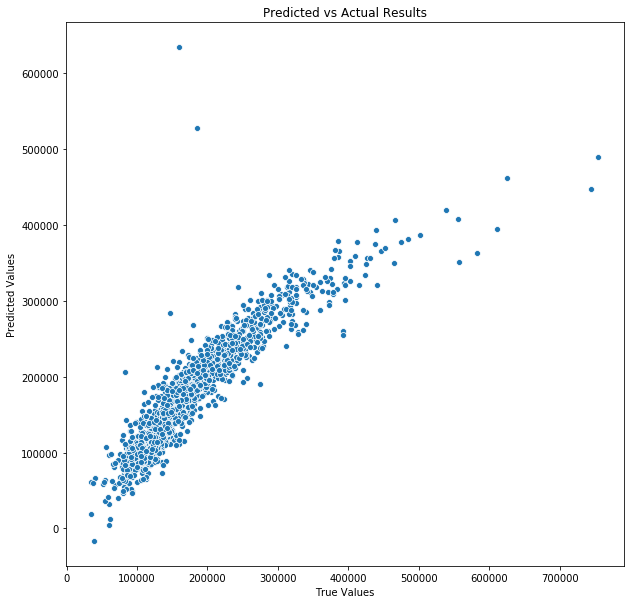

In [17]:
# Comparing predicted results to actual results
plt.title
ax = sns.scatterplot(x = 'True Values', 
                     y = 'Predicted Values', 
                     data = pd.DataFrame({'True Values': y, 'Predicted Values': y_pred}))\
                    .set_title('Predicted vs Actual Results')

In [18]:
# Cross validate our model
cross_val_score = cross_val_score(lr, X, y, cv=5, n_jobs=-1)

# Print the results of our cross validation matrix
print('Cross validation score: {:.5f}(+/- {:.2f})\n'.format(cross_val_score.mean(), cross_val_score.std()*2))

Cross validation score: 0.79123(+/- 0.16)



In [19]:
# Create dataframe to track runtime and scores
models = ['Logistic regression' , 'Random forest', 'Gradient Boosting', 'Neural Networks']
runtime = []
train_score = []
test_score = []

In [20]:
def run_model(model):
    
    # Train the model
    train_set = cross_val_score(model, X, y, cv=5, n_jobs=-1)
    
    # Test and time the model
    start_time = timeit.default_timer()
    test_set = cross_val_score(model, X, y, cv=5, n_jobs=-1)
    elapsed_time = timeit.default_timer() - start_time
    
    # Append the scores and runtime to our dataframe
    train_score.append(train_set.mean())
    test_score.append(test_set.mean())
    runtime.append(elapsed_time)
    
    # Fit the model to the data
    model.fit(X_train_tfidf, y_train_tfidf)
    
    # Store the predicted values in a dataframe
    y_pred = model.predict(X_test_tfidf)
    
    # Print scores and runtime
    print(str(model), '\n\nTrain score: {:.5f}(+/- {:.2f})\n'.format(train_set.mean(), train_set.std()*2))
    print('Test score: {:.5f}(+/- {:.2f})\n'.format(test_set.mean(), test_set.std()*2))
    print('Runtime:', elapsed_time, 'seconds\n')
    
    # Generate and print the confusion matrix
    print('Confusion matrix:\n\n', confusion_matrix(y_test, y_pred))
    
    # Print the model's statisitcs
    print('\nClassification Report:\n\n' + classification_report(y_test, y_pred))

In [ ]:
get_ipython().run_cell_magic('html', '', '<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>')